# Time series regression

This is a companion notebook for the excellent book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 


- Case study: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

## Import data

- We first need to download the data

- Mac user: use [homebrew](https://brew.sh) to install the following packages:

```bash
brew install openssl
```


```bash
brew install wget
```

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [ ]:
!unzip jena_climate_2009_2016.csv.zip

- Inspecting the data of the Jena weather dataset

In [29]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


- This outputs a count of 420,551 lines of data (each line is a timestep: a record of a
date and 14 weather-related values), as well as the header.

- Now, convert all 420,551 lines of data into NumPy arrays: 

  - one array for the temperature (in degrees Celsius), 
  - and another one for the rest of the data—the features we will use to predict future temperatures. 
  - Note that we discard the “Date Time” column.

In [30]:
import numpy as np

temperature = np.zeros((len(lines),))

raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

- Plotting the temperature timeseries

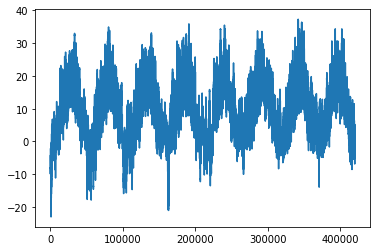

In [31]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature);

- Plotting the first 10 days of the temperature timeseries

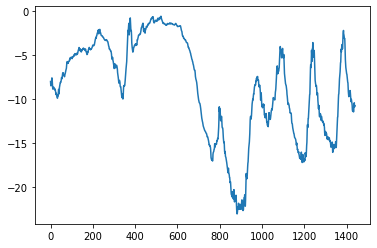

In [32]:
plt.plot(range(1440), temperature[:1440]);

## Data split

- In all our time series projects, we’ll use 
  - the first 50% of the data for training, 
  - the following 25% for validation, 
  - and the last 25% for testing

> When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that

- Computing the number of samples we'll use for each data split:

In [33]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))

num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Normalizing the data

- We’re going to use the first 210,225 timesteps as
training data, so we’ll compute the mean and standard deviation only on this fraction
of the data.

In [34]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Batch the data

- Next, let’s create a Dataset object that yields batches of data from the past five days
along with a target temperature 24 hours in the future. 

### Example

- To understand what timeseries_dataset_from_array() does, let’s look at a simple
example. 


- The general idea is that you provide an array of timeseries data (the
data argument), and `timeseries_dataset_from_array()` gives you windows
extracted from the original timeseries (we’ll call them “sequences”)


- For example, if you use 
  
  - data = [0 1 2 3 4 5 6] and 
  - sequence_length=3, then
  - timeseries_dataset_from_array() will generate the following samples: [0 1 2],
[1 2 3], [2 3 4], [3 4 5], [4 5 6].


- You can also pass a targets argument (an array) to timeseries_dataset_
from_array(). 

- The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. 


- So if you’re doing timeseries forecasting, targets should be the same array as data, offset
by some amount.

- For instance, with
  - data = [0 1 2 3 4 5 6 …] and 
  - sequence_length=3, 
  - you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]. 


  
- Let’s try it:

In [35]:
import numpy as np
from tensorflow import keras

# generate an array of sorted integers from 0 to 9
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    # The sequences we generate will be sampled from [0 1 2 3 4 5 6]
    data=int_sequence[:-3],
    # The target for the sequences that starts at data [N] will be the data [N+3]
    targets=int_sequence[3:],
    # The sequences will be 3 steps long
    sequence_length=3,
    # The sequences will be batched in batches of size 2
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### Instantiating dataset

- We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for
training, one for validation, and one for testing.



- We’ll use the following parameter values:

  - *sampling_rate* = 6 (Observations will be sampled at one data point per hour: we will only keep one data point out of 6).
  
  - *sequence_length* = 120 (Observations will go back 5 days (120 hours)).
  
  - *delay* = sampling_rate *  (sequence_length + 24 - 1) (The target for a sequence
will be the temperature 24 hours after the end of the sequence)

- When making the training dataset, we’ll pass start_index = 0 and end_index =
num_train_samples to only use the first 50% of the data. 

- For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. 

- Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

In [36]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

- Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples,
each containing 120 consecutive hours of input data, and targets is the corresponding
array of 256 target temperatures. 

- Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

**Inspecting the output of one of our datasets**

In [37]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## Baseline

- Next, we create a common-sense, non-machine-learning baseline

- The temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as
well as periodical with a daily period. 

- Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. 

- Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

- Computing the common-sense baseline MAE

- The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence. 

- Recall that we normalized our features, so to retrieve a temperature in degrees Celsius,
we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.

In [38]:
def evaluate_naive_method(dataset):

    total_abs_err = 0.
    samples_seen = 0
    
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


- This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a
test MAE of 2.62 degrees Celsius. 

- So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.

## LSTM model

- A densely connected approach would flatten the timeseries, which removes the notion of time from the input data. 

- The convolutional approach would treat every segment of the data in the same way, even applying pooling, which would destroy order information. 

- Let’s instead look at the data as what it is: a sequence, where causality and order matter.

- There’s a family of neural network architectures designed specifically for this use
case: 
  - recurrent neural networks.


- Among them, the Long Short Term Memory (LSTM).

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(16)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

- We use a callback to save the bestperforming modeland the EarlyStopping callback to interrupt training when the validation loss is not longer improving.

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint("time_jena_lstm.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2)
]

In [41]:
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])

In [42]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 31s 36ms/step - loss: 42.3810 - mae: 4.7274 - val_loss: 12.5027 - val_mae: 2.6867
Epoch 2/10
819/819 [==============================] - 29s 36ms/step - loss: 11.0010 - mae: 2.5712 - val_loss: 9.3673 - val_mae: 2.3679
Epoch 3/10
819/819 [==============================] - 29s 36ms/step - loss: 9.7402 - mae: 2.4310 - val_loss: 9.4872 - val_mae: 2.3932
Epoch 4/10
819/819 [==============================] - 29s 36ms/step - loss: 9.2918 - mae: 2.3698 - val_loss: 9.6254 - val_mae: 2.4155
Epoch 5/10
819/819 [==============================] - 29s 36ms/step - loss: 8.9737 - mae: 2.3253 - val_loss: 9.6151 - val_mae: 2.4265
Epoch 6/10
819/819 [==============================] - 29s 36ms/step - loss: 8.6780 - mae: 2.2857 - val_loss: 9.8057 - val_mae: 2.4417
Epoch 7/10
819/819 [==============================] - 29s 36ms/step - loss: 8.4248 - mae: 2.2536 - val_loss: 9.8438 - val_mae: 2.4463


In [43]:
model = keras.models.load_model("time_jena_lstm.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 11.1662 - mae: 2.6056
Test MAE: 2.61


- Define function to plot data

In [44]:
import matplotlib.pyplot as plt

def visualize_mae(history, title):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)

    plt.figure()

    plt.plot(epochs, loss, "b", label="Training MAE")
    plt.plot(epochs, val_loss, "r", label="Validation MAE")

    plt.title(title)
    plt.axhline(y=2.62, color='k', linestyle='--', label='Baseline')
    plt.xlabel("Epochs")
    plt.ylabel("Mean absolute error")
    plt.legend()
    plt.show()

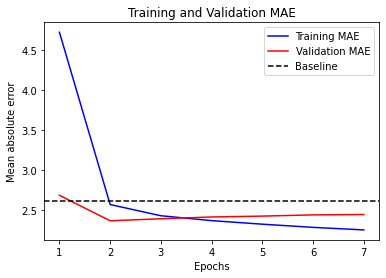

In [45]:
visualize_mae(history, "Training and Validation MAE")

## LSTM with dropout

- Using recurrent dropout to fight overfitting

- Training and evaluating a dropout-regularized LSTM

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint("time_jena_lstm_dropout.keras",
                                    save_best_only=True),
       keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2)
]

In [48]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10, # we use 10 instead of 50
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 28.5826 - mae: 3.9429 - val_loss: 9.8555 - val_mae: 2.4362
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 14.8545 - mae: 2.9914 - val_loss: 9.4010 - val_mae: 2.3751
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 13.9669 - mae: 2.9001 - val_loss: 9.6470 - val_mae: 2.4053
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 13.2885 - mae: 2.8275 - val_loss: 9.7995 - val_mae: 2.4221
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 12.7552 - mae: 2.7719 - val_loss: 9.4762 - val_mae: 2.3890
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 12.4207 - mae: 2.7304 - val_loss: 9.3058 - val_mae: 2.3698
Epoch 7/10
819/819 [==============================] - 50s 61ms/step - loss: 12.1240 - mae: 2.6987 - val_loss: 9.5247 - val_mae: 2.3964
Epoch 8/10
819/819 [==============================] - 5

In [49]:
model = keras.models.load_model("time_jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 6s 14ms/step - loss: 10.5165 - mae: 2.5628
Test MAE: 2.56


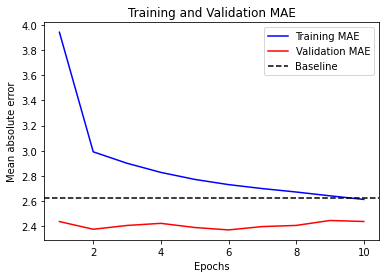

In [50]:
visualize_mae(history, "Training and Validation MAE")

### Stacking recurrent layers with a GRU model

- Next, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. 

- GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

- Training and evaluating a dropout-regularized, stacked GRU model

In [51]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint("time_jena_stacked_gru_dropout.keras",
                                    save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2)                            
]

In [53]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [54]:
history = model.fit(train_dataset,
                    epochs=15, # we use 15 instead of 50
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 87s 103ms/step - loss: 25.8544 - mae: 3.7457 - val_loss: 9.1854 - val_mae: 2.3396
Epoch 2/15
819/819 [==============================] - 84s 102ms/step - loss: 14.0295 - mae: 2.9008 - val_loss: 9.1922 - val_mae: 2.3686
Epoch 3/15
819/819 [==============================] - 83s 102ms/step - loss: 13.2653 - mae: 2.8233 - val_loss: 9.5157 - val_mae: 2.4060
Epoch 4/15
819/819 [==============================] - 84s 102ms/step - loss: 12.6756 - mae: 2.7587 - val_loss: 8.8680 - val_mae: 2.3081
Epoch 5/15
819/819 [==============================] - 84s 103ms/step - loss: 12.1866 - mae: 2.7104 - val_loss: 8.6341 - val_mae: 2.2816
Epoch 6/15
819/819 [==============================] - 84s 102ms/step - loss: 11.8177 - mae: 2.6686 - val_loss: 9.9712 - val_mae: 2.4629
Epoch 7/15
819/819 [==============================] - 84s 102ms/step - loss: 11.4186 - mae: 2.6204 - val_loss: 9.0453 - val_mae: 2.3302
Epoch 8/15
819/819 [============================

In [55]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 9s 21ms/step - loss: 9.8207 - mae: 2.4722
Test MAE: 2.47


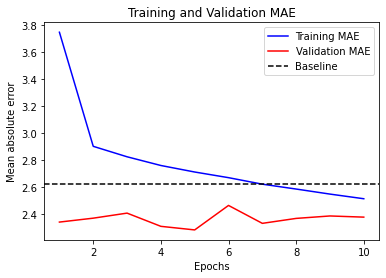

In [56]:
visualize_mae(history, "Training and Validation MAE")